# Small model for CIFAR10

## Configuration

Imports

In [1]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
import ignite.metrics
import ignite.contrib.handlers

Configuration

In [2]:
DATA_DIR='./data'

IMAGE_SIZE = 32

NUM_CLASSES = 10
NUM_WORKERS = 8
BATCH_SIZE = 128
EPOCHS = 100

LEARNING_RATE = 1e-2
WEIGHT_DECAY = 1e-2

In [3]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device:", DEVICE)

device: cuda


## Data

In [4]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.1)
])

In [5]:
train_dset = datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=train_transform)
val_dset = datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [6]:
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True,
                                           num_workers=NUM_WORKERS, pin_memory=True)

val_loader = torch.utils.data.DataLoader(val_dset, batch_size=BATCH_SIZE, shuffle=False,
                                         num_workers=NUM_WORKERS, pin_memory=True)

## Model

Utilities

In [7]:
class NormAct(nn.Sequential):
    def __init__(self, channels):
        super().__init__(
            nn.BatchNorm2d(channels),
            nn.GELU()
        )

In [8]:
class ConvBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        super().__init__(
            NormAct(in_channels),
            nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, groups=groups),
        )

In [9]:
class Residual(nn.Module):
    def __init__(self, *layers, shortcut=None):
        super().__init__()
        self.residual = nn.Sequential(*layers) if len(layers) > 1 else layers[0]
        self.shortcut = shortcut if shortcut is not None else nn.Identity()
        self.gamma = nn.Parameter(torch.tensor(0.))
    
    def forward(self, x):
        return self.shortcut(x) + self.gamma * self.residual(x)

Block

In [10]:
class Block(Residual):
    def __init__(self, channels, kernel_size=3, stride=1, mult=4):
        mid_channels = channels * mult
        kernel_size = kernel_size + stride - 1
        super().__init__(
            ConvBlock(channels, mid_channels, kernel_size, stride, groups=channels),
            ConvBlock(mid_channels, channels, 1),
            shortcut = nn.AvgPool2d(stride) if stride > 1 else None
        )

Stage

In [11]:
class Stage(nn.Sequential):
    def __init__(self, channels, num_blocks, kernel_size=3, stride=1, mult=4):
        super().__init__(
            Block(channels, kernel_size, stride, mult),
            *[Block(channels, kernel_size, 1, mult) for _ in range(num_blocks - 1)]
        )

In [12]:
class StageStack(nn.Sequential):
    def __init__(self, channels, num_blocks, strides, kernel_size=3, mult=4):
        super().__init__(*[Stage(channels, num_blocks, kernel_size, stride, mult) for stride in strides])

Main model

In [13]:
def Stem(in_channels, out_channels, kernel_size=3, stride=1):
    padding = (kernel_size - 1) // 2
    return nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding, stride=stride)

In [14]:
class Head(nn.Sequential):
    def __init__(self, channels, classes, p_drop=0.):
        super().__init__(
            NormAct(channels),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(p_drop),
            nn.Linear(channels, classes)
        )

In [15]:
class Net(nn.Sequential):
    def __init__(self, classes, channels, num_blocks, strides, mult=4, in_channels=3, head_p_drop=0.):
        super().__init__(
            Stem(in_channels, channels, 3, strides[0]),
            StageStack(channels, num_blocks, strides[1:], 3, mult),
            Head(channels, classes, head_p_drop)
        )

Model creation

In [16]:
def init_linear(m):
    if isinstance(m, (nn.Conv2d, nn.Conv1d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None: nn.init.zeros_(m.bias)

In [17]:
model = Net(classes = NUM_CLASSES,
            channels = 128,
            num_blocks = 2,
            strides = [1, 1, 2, 2, 2],
            head_p_drop = 0.3)

In [18]:
model.apply(init_linear);

In [19]:
model.to(DEVICE);

In [20]:
print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

Number of parameters: 592,402


## Training

### Trainer setup

In [21]:
loss = nn.CrossEntropyLoss(label_smoothing=0.1)

In [22]:
optimizer = optim.AdamW(model.parameters(), lr=1e-6, weight_decay=WEIGHT_DECAY)

Trainer

In [23]:
trainer = create_supervised_trainer(model, optimizer, loss, device=DEVICE)

In [24]:
lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE,
                                             steps_per_epoch=len(train_loader), epochs=EPOCHS)

In [25]:
trainer.add_event_handler(Events.ITERATION_COMPLETED, lambda engine: lr_scheduler.step());

In [26]:
ignite.metrics.RunningAverage(output_transform=lambda x: x).attach(trainer, "loss")

Evaluator

In [27]:
val_metrics = {"accuracy": ignite.metrics.Accuracy(), "loss": ignite.metrics.Loss(loss)}

In [28]:
evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=DEVICE)

In [29]:
history = defaultdict(list)

In [30]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    train_state = engine.state
    epoch = train_state.epoch
    max_epochs = train_state.max_epochs
    train_loss = train_state.metrics["loss"]
    history['train loss'].append(train_loss)
    
    evaluator.run(val_loader)
    val_metrics = evaluator.state.metrics
    val_loss = val_metrics["loss"]
    val_acc = val_metrics["accuracy"]
    history['val loss'].append(val_loss)
    history['val acc'].append(val_acc)
    
    print("{}/{} - train: loss {:.3f}; val: loss {:.3f} accuracy {:.3f}".format(
        epoch, max_epochs, train_loss, val_loss, val_acc))

### Start training

In [34]:
trainer.run(train_loader, max_epochs=EPOCHS);

1/100 - train: loss 1.604; val: loss 1.479 accuracy 0.556
2/100 - train: loss 1.341; val: loss 1.273 accuracy 0.665
3/100 - train: loss 1.198; val: loss 1.166 accuracy 0.717
4/100 - train: loss 1.113; val: loss 1.095 accuracy 0.751
5/100 - train: loss 1.033; val: loss 1.007 accuracy 0.785
6/100 - train: loss 0.982; val: loss 0.965 accuracy 0.813
7/100 - train: loss 0.932; val: loss 0.935 accuracy 0.820
8/100 - train: loss 0.915; val: loss 0.940 accuracy 0.819
9/100 - train: loss 0.885; val: loss 0.869 accuracy 0.849
10/100 - train: loss 0.861; val: loss 0.868 accuracy 0.846
11/100 - train: loss 0.850; val: loss 0.829 accuracy 0.865
12/100 - train: loss 0.828; val: loss 0.854 accuracy 0.858
13/100 - train: loss 0.813; val: loss 0.861 accuracy 0.850
14/100 - train: loss 0.798; val: loss 0.814 accuracy 0.870
15/100 - train: loss 0.793; val: loss 0.836 accuracy 0.860
16/100 - train: loss 0.783; val: loss 0.789 accuracy 0.880
17/100 - train: loss 0.776; val: loss 0.792 accuracy 0.880
18/100

In [35]:
def history_plot_train_val(history, key):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    xs = np.arange(1, len(history['train ' + key]) + 1)
    ax.plot(xs, history['train ' + key], '.-', label='train')
    ax.plot(xs, history['val ' + key], '.-', label='val')
    ax.set_xlabel('epoch')
    ax.set_ylabel(key)
    ax.legend()
    ax.grid()
    plt.show()

In [36]:
def history_plot(history, key):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    xs = np.arange(1, len(history[key]) + 1)
    ax.plot(xs, history[key], '.-')
    ax.set_xlabel('epoch')
    ax.set_ylabel(key)
    ax.grid()
    plt.show()

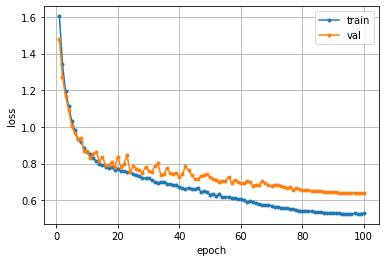

In [37]:
history_plot_train_val(history, 'loss')

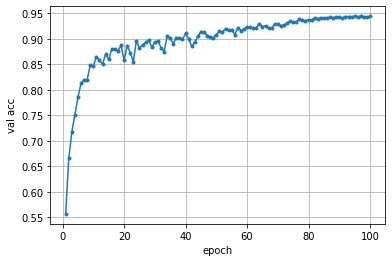

In [38]:
history_plot(history, 'val acc')